# Regression Models

## Get Broccoli Data

In [1]:
%reset

# Datenabfrage von Server-DB
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class font:
    BOLD = '\033[1m'
    END = '\033[0m'
    UNDERLINE = '\033[4m'

# Liste der Daten, die berücksichtigt werden
dates = ['2019-04-18', '2019-04-25', '2019-05-01', '2019-05-09', '2019-05-16', '2019-05-24']

# Angeben, ob Blacklist einbezogen wird
useBlacklist = True

# Verbindungsaufbau
server = 'deepbroccoliserver.database.windows.net'
database = 'DeepBroccoliDatabase'
username = 'ntb'
password = 'brokkoli_2019'
driver= '{SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

# Abfrage definieren und ausführen: Alle Brokkoli mit allen dazugehörigen Messwerten 
query = '''
select dbo.broccoli.id, dbo.broccolivalues.timestamp, dbo.broccoli.lat, dbo.broccoli.long, dbo.broccolivalues.pixelCount, 
dbo.broccolivalues.maxNDVI, dbo.broccolivalues.minNDVI, dbo.broccolivalues.meanNDVI, dbo.broccolivalues.medianNDVI, 
dbo.broccolivalues.NDVI_15_QUANTILE, dbo.broccolivalues.NDVI_25_QUANTILE, dbo.broccolivalues.NDVI_75_QUANTILE, 
dbo.broccolivalues.NDVI_85_QUANTILE,
dbo.broccolivalues.maxNDRE, dbo.broccolivalues.minNDRE, dbo.broccolivalues.meanNDRE, dbo.broccolivalues.medianNDRE,
dbo.broccolivalues.NDRE_15_QUANTILE, dbo.broccolivalues.NDRE_25_QUANTILE, dbo.broccolivalues.NDRE_75_QUANTILE,
dbo.broccolivalues.NDRE_85_QUANTILE
from dbo.broccoli inner join dbo.broccolivalues on dbo.broccoli.id = dbo.broccolivalues.id'''

# Blacklist einbeziehen: Brokkoli-IDs in Blacklist werden gefiltert
if useBlacklist:
    query = query + ''' where dbo.broccoli.id not in (select broccoli_id from dbo.broccoliBlacklist)'''

SQL_Query = pd.read_sql_query(query, cnxn)
broccoli_data = pd.DataFrame(SQL_Query)
cnxn.close()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [8]:
id1 = broccoli_data[broccoli_data['id'] == 1]
id1['timestamp'] = pd.to_datetime(id1['timestamp'], yearfirst=True)
id1.set_index('timestamp',inplace=True, drop=True)
tmp_mean = id1.resample('D').mean()


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Get weather data

In [9]:
# Abfrage definieren und ausführen: Alle Meteomatics-Daten
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
SQL_Query = pd.read_sql_query('SELECT * FROM dbo.meteomatics', cnxn)
meteomatics_data = pd.DataFrame(SQL_Query)
cnxn.close()

meteomatics_data.head()

,timestamp,temperature,relativeHumidity,absoluteHumidity,dewPoint,wind,cloudCover,precipitation,precipitationType,precipitationProbability,hail,evaporation,frostDepth,radiation,accumulatedEnergy,evapotranspiration,growingDegreeDays,leafWetness
0,2019-04-08 09:00:00.243,7.4,93.800003,7.5,6.5,1.5,100.000000,0.10,0.0,5.7,0.0,-0.04,0.0,337.299988,59040.500000,0.04,NaN,1.0
1,2019-04-08 07:56:07.257,7.0,93.900002,7.3,6.1,0.4,99.000000,0.04,0.0,1.0,0.0,-0.01,0.0,126.000000,40193.898438,0.00,NaN,1.0
2,2019-04-08 07:56:37.323,7.0,93.900002,7.3,6.1,0.4,99.000000,0.04,0.0,1.0,0.0,-0.01,0.0,126.000000,40193.898438,0.00,NaN,1.0
3,2019-04-08 10:00:00.207,7.8,94.199997,7.7,7.0,0.8,100.000000,0.03,0.0,1.0,0.0,-0.09,0.0,529.599976,19428.500000,0.06,NaN,1.0
4,2019-04-08 14:00:00.203,11.2,68.800003,7.0,5.7,1.6,97.599998,0.00,0.0,1.0,0.0,-0.17,0.0,848.700012,856912.625000,0.25,0.0,0.0


In [10]:

meteomatics_data['timestamp'] = pd.to_datetime(meteomatics_data['timestamp'])
meteomatics_data.set_index("timestamp", drop=True, inplace=True)
tmp_weather = meteomatics_data.resample('D').median()
tmp_weather_sum = meteomatics_data.resample('D').sum()
tmp_weather['precipitation'] = tmp_weather_sum['precipitation']
tmp_weather['accumulatedEnergy'] = tmp_weather_sum['accumulatedEnergy']
tmp_weather_sum.describe()

,temperature,relativeHumidity,absoluteHumidity,dewPoint,wind,cloudCover,precipitation,precipitationType,precipitationProbability,hail,evaporation,frostDepth,radiation,accumulatedEnergy,evapotranspiration,growingDegreeDays,leafWetness
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,51.000000,51.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000
mean,252.015686,1736.425490,167.505882,129.500000,73.678431,1600.600001,3.055882,3.137255,152.419608,0.0,-1.985294,0.090196,7873.129426,8.771256e+06,2.410784,503.231372,8.392157
std,78.394154,352.074322,33.998685,69.902778,52.588338,729.298858,5.910496,4.808408,239.925469,0.0,0.813224,0.644129,693.992314,8.099015e+06,1.439248,509.545700,5.786462
min,114.100001,832.099995,118.699999,8.600000,22.200000,0.100000,0.000000,0.000000,22.700000,0.0,-3.480000,0.000000,6598.300052,5.130390e+04,0.430000,0.000000,0.000000
25%,190.500000,1536.549994,144.299999,83.050000,35.400000,1021.750002,0.000000,0.000000,24.000000,0.0,-2.605000,0.000000,7302.950005,1.022798e+06,1.180000,0.000000,3.500000
50%,256.700002,1818.899998,159.200000,114.200001,52.999999,1800.000000,0.550000,1.000000,40.900000,0.0,-2.180000,0.000000,7974.300022,6.650497e+06,2.010000,425.900002,9.000000
75%,310.750001,2017.750000,184.200000,172.450000,97.200000,2284.200010,3.905000,4.500000,193.549999,0.0,-1.180000,0.000000,8478.849978,1.585526e+07,3.255000,837.750015,12.500000
max,399.999992,2263.900002,257.100000,292.000002,243.900001,2400.000000,32.740000,21.000000,1247.300000,0.0,-0.580000,4.600000,8881.000025,2.574915e+07,6.160000,1553.999954,19.000000


In [11]:
tmp_weather.describe()

,temperature,relativeHumidity,absoluteHumidity,dewPoint,wind,cloudCover,precipitation,precipitationType,precipitationProbability,hail,evaporation,frostDepth,radiation,accumulatedEnergy,evapotranspiration,growingDegreeDays,leafWetness
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,51.000000,51.0,51.000000,5.100000e+01,51.000000,38.000000,51.000000
mean,10.410784,73.419608,7.091176,5.616667,2.853922,68.957843,3.055882,0.078431,3.500980,0.0,-0.026275,0.0,148.273530,8.771256e+06,0.055294,60.555263,0.284314
std,3.160622,15.814218,1.487236,2.981974,2.337003,40.219199,5.910496,0.271524,9.120809,0.0,0.019075,0.0,68.642608,8.099015e+06,0.045315,30.128003,0.438804
min,4.350000,34.100000,4.800000,0.250000,0.850000,0.000000,0.000000,0.000000,1.000000,0.0,-0.080000,0.0,56.949998,5.130390e+04,0.010000,0.000000,0.000000
25%,8.000000,64.949999,6.100000,3.775000,1.225000,41.725000,0.000000,0.000000,1.000000,0.0,-0.030000,0.0,98.200001,1.022798e+06,0.030000,47.349999,0.000000
50%,10.600000,77.750000,6.700000,5.200000,2.050000,97.450001,0.550000,0.000000,1.000000,0.0,-0.020000,0.0,145.350002,6.650497e+06,0.040000,62.299999,0.000000
75%,12.300000,85.350000,7.950000,7.475000,3.550000,100.000000,3.905000,0.000000,1.000000,0.0,-0.015000,0.0,187.500000,1.585526e+07,0.065000,79.400002,0.750000
max,16.200000,96.599998,10.950000,12.650000,10.700000,100.000000,32.740000,1.000000,52.900000,0.0,0.000000,0.0,446.599991,2.574915e+07,0.215000,115.300003,1.000000


In [12]:
whole_df = pd.concat([tmp_weather, tmp_mean], axis=1)
whole_df['2019-04-18':'2019-05-24']

,temperature,relativeHumidity,absoluteHumidity,dewPoint,wind,cloudCover,precipitation,precipitationType,precipitationProbability,hail,...,NDVI_75_QUANTILE,NDVI_85_QUANTILE,maxNDRE,minNDRE,meanNDRE,medianNDRE,NDRE_15_QUANTILE,NDRE_25_QUANTILE,NDRE_75_QUANTILE,NDRE_85_QUANTILE
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-18,12.20,56.450001,6.70,5.25,2.95,20.600000,0.00,0.0,1.00,0.0,...,0.416200,0.416200,0.143159,0.033404,0.093616,0.094714,0.036293,0.076734,0.122912,0.140458
2019-04-19,13.55,48.699999,6.45,4.90,6.80,0.000000,0.00,0.0,1.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-20,14.95,52.549999,6.05,4.00,2.35,0.000000,0.00,0.0,1.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-21,14.60,38.600000,5.30,2.10,2.90,0.000000,0.00,0.0,1.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-22,16.20,34.100000,5.20,1.60,8.55,9.550000,0.00,0.0,1.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23,15.00,45.450001,6.50,4.80,7.70,75.549999,1.07,0.0,1.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-24,15.25,45.800001,6.40,4.60,7.40,50.000000,0.01,0.0,1.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-25,16.10,37.049999,4.90,0.70,10.70,90.600002,0.00,0.0,1.00,0.0,...,0.567214,0.616035,0.258980,0.004312,0.135549,0.125361,0.060132,0.071596,0.197525,0.204966
2019-04-26,8.85,85.200001,7.00,5.70,1.65,99.950001,16.73,0.0,3.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
whole_df.describe()

,temperature,relativeHumidity,absoluteHumidity,dewPoint,wind,cloudCover,precipitation,precipitationType,precipitationProbability,hail,...,NDVI_75_QUANTILE,NDVI_85_QUANTILE,maxNDRE,minNDRE,meanNDRE,medianNDRE,NDRE_15_QUANTILE,NDRE_25_QUANTILE,NDRE_75_QUANTILE,NDRE_85_QUANTILE
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,10.410784,73.419608,7.091176,5.616667,2.853922,68.957843,3.055882,0.078431,3.500980,0.0,...,0.630367,0.645414,0.211459,0.006249,0.113286,0.112421,0.056851,0.079583,0.151198,0.164335
std,3.160622,15.814218,1.487236,2.981974,2.337003,40.219199,5.910496,0.271524,9.120809,0.0,...,0.126991,0.127488,0.054979,0.034067,0.019812,0.017572,0.018867,0.016754,0.032497,0.028555
min,4.350000,34.100000,4.800000,0.250000,0.850000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.416200,0.416200,0.143159,-0.047984,0.086083,0.087650,0.036293,0.061727,0.109005,0.128353
25%,8.000000,64.949999,6.100000,3.775000,1.225000,41.725000,0.000000,0.000000,1.000000,0.0,...,0.578399,0.618382,0.169538,-0.009493,0.098493,0.099099,0.043284,0.068949,0.128148,0.143758
50%,10.600000,77.750000,6.700000,5.200000,2.050000,97.450001,0.550000,0.000000,1.000000,0.0,...,0.655811,0.665553,0.215273,0.009804,0.117362,0.118759,0.054059,0.074165,0.154718,0.166353
75%,12.300000,85.350000,7.950000,7.475000,3.550000,100.000000,3.905000,0.000000,1.000000,0.0,...,0.732320,0.741965,0.257462,0.028877,0.127709,0.125337,0.065902,0.089461,0.167628,0.179408
max,16.200000,96.599998,10.950000,12.650000,10.700000,100.000000,32.740000,1.000000,52.900000,0.0,...,0.743963,0.755082,0.269229,0.046558,0.135549,0.129281,0.087156,0.105673,0.197525,0.204966


In [14]:
from plotly import iplot

ModuleNotFoundError: No module named 'plotly'

AttributeError: Unknown property mode

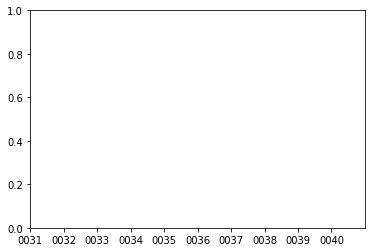

In [133]:
whole_df[['temperature', 'pixelCount']].iplot(
    mode='lines+markers',
    opacity=0.8,
    size=8,
    symbol=1,
    xTitle='Time',
    yTitle='Temperature',
    title='Temperature over last 10 years')